<h1 align="center">MSIN0114: Business Analytics Consulting Project</h1>
<h2 align="center">Profitability of Client X projects: run 2</h2>

## Notebook Setup

In [1]:
# Essentials
import pandas as pd
from pandas import Series, DataFrame
from pandas.api.types import CategoricalDtype
pd.options.display.max_columns = None
import sqlite3
import pyodbc
import numpy as np; np.random.seed(1)

# Image creation and display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from matplotlib import pyplot
import plotly.express as px
import plotly.graph_objects as go
from matplotlib.ticker import FuncFormatter
from sklearn.inspection import permutation_importance

# Preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

# Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.naive_bayes import GaussianNB

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 

from sklearn.decomposition import PCA

# Metrics of accuracy
from numpy import mean
from numpy import std
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from pycm import *
import imbalanced_ensemble as imbens
from imbalanced_ensemble.ensemble.base import sort_dict_by_key
from collections import Counter

# Fine-tuning and enseble learning
from pprint import pprint
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV

# Other
import itertools as it
import io
import os
os.sys.path
import sys
import glob
import concurrent.futures
from __future__ import print_function
import binascii
import struct
from PIL import Image
import scipy
import scipy.misc
import scipy.cluster
import datetime, time
import functools, operator
from datetime import datetime
from numpy.random import seed
from numpy.random import randn
from numpy import percentile

In [2]:
df = pd.read_csv('csv-files/binary_data.csv')

## Data splitting and training

In [21]:
Y = df[['Profit_Class']]
X = df.drop(columns = ['Rec_Class', 'Profit_Class'])
X1 = pd.DataFrame(preprocessing.normalize(X))
X1.columns = X.columns
X = X1
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=1, stratify = Y)


In [4]:
# Logistic regression
log = LogisticRegression(random_state = 1, max_iter = 30000)
log.fit(X_train, Y_train.values.ravel())
log_y_pred=log.predict(X_test)

# Ridge regression
rdg = RidgeClassifier(alpha=1.0, random_state = 1, max_iter = 30000)
rdg.fit(X_train, Y_train.values.ravel())
rdg_y_pred=rdg.predict(X_test)

# k-Neighbours
np.random.seed(1)
knn_100 = KNeighborsClassifier(n_neighbors=100)
knn_100.fit(X_train, Y_train.values.ravel())
knn_100_y_pred = knn_100.predict(X_test)

# Decision tree classifier
dtc = DecisionTreeClassifier(random_state = 1)
dtc = dtc.fit(X_train, Y_train.values.ravel())
dtc_y_pred = dtc.predict(X_test)

# Tuned random forest classifier
rfc_tuned = RandomForestClassifier(max_depth=60, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=1788, random_state=1)
rfc_tuned.fit(X_train, Y_train.values.ravel())

# XGBoost classifier
xgbc = XGBClassifier(n_estimators=100, learning_rate=0.05, booster='gbtree', random_state = 1, eval_metric='mlogloss', objective='binary:logistic', use_label_encoder=False)
xgbc.fit(X_train, Y_train.values.ravel())
xgbc_y_pred=xgbc.predict(X_test)

# Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, Y_train.values.ravel())
gnb_y_pred = gnb.predict(X_test)

# Linear discriminant analysis
lda = LinearDiscriminantAnalysis(n_components = 1)
lda.fit(X_train, Y_train.values.ravel())
lda_y_pred = lda.predict(X_test)

# Quadratic discriminant analysis
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, Y_train.values.ravel())
qda_y_pred = qda.predict(X_test)

# Tuned support vector machine
svm_tuned = SVC(kernel='rbf', C = 2, gamma = 1, random_state = 1, probability=True)
svm_tuned.fit(X_train, Y_train.values.ravel())
svm_y_pred = svm_tuned.predict(X_test)

# Soft voting classifier
soft_voting = VotingClassifier(
    estimators=[('xgbc', xgbc), ('rfc_t', rfc_tuned)],
    voting='soft')
soft_voting.fit(X_train, Y_train.values.ravel())
sv_y_pred = soft_voting.predict(X_test)

## Stacking

#### 8.2.1  <a class="anchor" id="8_2_1"></a> Top 9 models

See results for **SV and tuned RFC** in pr_run_1, **base XGBC** in pr_run_3.

#### 8.2.2  <a class="anchor" id="8_2_2"></a> Top 8 models

See results for **SV** in pr_run_1, **tuned RFC** in pr_run_3.

In [28]:
# Get a stacking ensemble of models
def get_stacking():
	# Define the base models
	level8 = list()
	level8.append(('dtc', dtc))
	level8.append(('rdg', rdg))
	level8.append(('lda', lda))
	level8.append(('log', log))
	level8.append(('svm_t', svm_tuned))
	level8.append(('rfc_t', rfc_tuned))
	level8.append(('xgbc', xgbc))
	level8.append(('sv', soft_voting))

	# Define the stacking ensemble
	model = StackingClassifier(estimators=level8, final_estimator=xgbc, cv=5)
	return model

# Define the base models separately
level8 = list()
level8.append(('dtc', dtc))
level8.append(('rdg', rdg))
level8.append(('lda', lda))
level8.append(('log', log))
level8.append(('svm_t', svm_tuned))
level8.append(('rfc_t', rfc_tuned))
level8.append(('xgbc', xgbc))
level8.append(('sv', soft_voting))
level8.append(('stacking', get_stacking()))

In [29]:
# Define the model
stack8_xgbc = StackingClassifier(estimators=level8, final_estimator=xgbc, cv=5)

# Fit the model on all available data
stack8_xgbc = stack8_xgbc.fit(X, Y.values.ravel())

# Predict the response for test set
stack8_xgbc_y_pred = stack8_xgbc.predict(X_test)

In [30]:
# Accuracy measures
print('Accuracy score with 8 models learnt on base XGBC: ' + str(round(metrics.accuracy_score(Y_test, np.round(stack8_xgbc_y_pred)), 3)*100)+'%')
print('Recall score  with 8 models learnt on soft base XGBC: ' + str(round(metrics.recall_score(Y_test, np.round(stack8_xgbc_y_pred), average='weighted'), 3)*100)+'%')
print('Precision score  with 8 models learnt on base XGBC: ' + str(round(metrics.precision_score(Y_test, np.round(stack8_xgbc_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('F1 score with 8 models learnt on base XGBC: ' + str(round(metrics.f1_score(Y_test, np.round(stack8_xgbc_y_pred), average='weighted'), 3)*100)+'%')

Accuracy score with 8 models learnt on base XGBC: 79.5%
Recall score  with 8 models learnt on soft base XGBC: 79.5%
Precision score  with 8 models learnt on base XGBC: 79.9%
F1 score with 8 models learnt on base XGBC: 79.5%


#### 8.2.3  <a class="anchor" id="8_2_3"></a> Top 7 models

See results for **SV** in pr_run_1, **tuned RFC** in pr_run_3.

In [31]:
# Get a stacking ensemble of models
def get_stacking():
	# Define the base models
	level7 = list()
	level7.append(('rdg', rdg))
	level7.append(('lda', lda))
	level7.append(('log', log))
	level7.append(('svm_t', svm_tuned))
	level7.append(('rfc_t', rfc_tuned))
	level7.append(('xgbc', xgbc))
	level7.append(('sv', soft_voting))

	# Define the stacking ensemble
	model = StackingClassifier(estimators=level7, final_estimator=xgbc, cv=5)
	return model

# Define the base models separately
level7 = list()
level7.append(('rdg', rdg))
level7.append(('lda', lda))
level7.append(('log', log))
level7.append(('svm_t', svm_tuned))
level7.append(('rfc_t', rfc_tuned))
level7.append(('xgbc', xgbc))
level7.append(('sv', soft_voting))
level7.append(('stacking', get_stacking()))

In [32]:
# Define the model
stack7_xgbc = StackingClassifier(estimators=level7, final_estimator=xgbc, cv=5)

# Fit the model on all available data
stack7_xgbc = stack7_xgbc.fit(X, Y.values.ravel())

# Predict the response for test set
stack7_xgbc_y_pred = stack7_xgbc.predict(X_test)

In [33]:
# Accuracy measures
print('Accuracy score with 7 models learnt on base XGBC: ' + str(round(metrics.accuracy_score(Y_test, np.round(stack7_xgbc_y_pred)), 3)*100)+'%')
print('Recall score  with 7 models learnt on base XGBC: ' + str(round(metrics.recall_score(Y_test, np.round(stack7_xgbc_y_pred), average='weighted'), 3)*100)+'%')
print('Precision score  with 7 models learnt on base XGBC: ' + str(round(metrics.precision_score(Y_test, np.round(stack7_xgbc_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('F1 score with 7 models learnt on base XGBC: ' + str(round(metrics.f1_score(Y_test, np.round(stack7_xgbc_y_pred), average='weighted'), 3)*100)+'%')

Accuracy score with 7 models learnt on base XGBC: 77.7%
Recall score  with 7 models learnt on base XGBC: 77.7%
Precision score  with 7 models learnt on base XGBC: 78.0%
F1 score with 7 models learnt on base XGBC: 77.7%


#### 8.2.4  <a class="anchor" id="8_2_4"></a> Top 6 models

See results for **SV** in pr_run_1, **tuned RFC** in pr_run_3.

In [5]:
# Get a stacking ensemble of models
def get_stacking():
	# Define the base models
	level6 = list()
	level6.append(('lda', lda))
	level6.append(('log', log))
	level6.append(('svm_t', svm_tuned))
	level6.append(('rfc_t', rfc_tuned))
	level6.append(('xgbc', xgbc))
	level6.append(('sv', soft_voting))

	# Define the stacking ensemble
	model = StackingClassifier(estimators=level6, final_estimator=xgbc, cv=5)
	return model

# Define the base models separately
level6 = list()
level6.append(('lda', lda))
level6.append(('log', log))
level6.append(('svm_t', svm_tuned))
level6.append(('rfc_t', rfc_tuned))
level6.append(('xgbc', xgbc))
level6.append(('sv', soft_voting))
level6.append(('stacking', get_stacking()))

In [6]:
# Define the model
stack6_xgbc = StackingClassifier(estimators=level6, final_estimator=xgbc, cv=5)

# Fit the model on all available data
stack6_xgbc = stack6_xgbc.fit(X, Y.values.ravel())

# Predict the response for test set
stack6_xgbc_y_pred = stack6_xgbc.predict(X_test)

In [7]:
# Accuracy measures
print('Accuracy score with 6 models learnt on base XGBC: ' + str(round(metrics.accuracy_score(Y_test, np.round(stack6_xgbc_y_pred)), 3)*100)+'%')
print('Recall score  with 6 models learnt on base XGBC: ' + str(round(metrics.recall_score(Y_test, np.round(stack6_xgbc_y_pred), average='weighted'), 3)*100)+'%')
print('Precision score  with 6 models learnt on base XGBC: ' + str(round(metrics.precision_score(Y_test, np.round(stack6_xgbc_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('F1 score with 6 models learnt on base XGBC: ' + str(round(metrics.f1_score(Y_test, np.round(stack6_xgbc_y_pred), average='weighted'), 3)*100)+'%')

Accuracy score with 6 models learnt on base XGBC: 78.2%
Recall score  with 6 models learnt on base XGBC: 78.2%
Precision score  with 6 models learnt on base XGBC: 78.3%
F1 score with 6 models learnt on base XGBC: 78.10000000000001%


#### 8.2.5  <a class="anchor" id="8_2_5"></a> Top 5 models

See results for **base XGBC and tuned RFC** in pr_run_1.

In [13]:
# Get a stacking ensemble of models
def get_stacking():
	# Define the base models
	level5 = list()
	level5.append(('log', log))
	level5.append(('svm_t', svm_tuned))
	level5.append(('rfc_t', rfc_tuned))
	level5.append(('xgbc', xgbc))
	level5.append(('sv', soft_voting))

	# Define the stacking ensemble
	model = StackingClassifier(estimators=level5, final_estimator=soft_voting, cv=5)
	return model

# Define the base models separately
level5 = list()
level5.append(('log', log))
level5.append(('svm_t', svm_tuned))
level5.append(('rfc_t', rfc_tuned))
level5.append(('xgbc', xgbc))
level5.append(('sv', soft_voting))
level5.append(('stacking', get_stacking()))

In [14]:
# Define the model
stack5_sv = StackingClassifier(estimators=level5, final_estimator=soft_voting, cv=5)

# Fit the model on all available data
stack5_sv = stack5_sv.fit(X, Y.values.ravel())

# Predict the response for test set
stack5_sv_y_pred = stack5_sv.predict(X_test)

In [15]:
# Accuracy measures
print('Accuracy score with 5 models learnt on soft voting classifier: ' + str(round(metrics.accuracy_score(Y_test, np.round(stack5_sv_y_pred)), 3)*100)+'%')
print('Recall score  with 5 models learnt on soft voting classifier: ' + str(round(metrics.recall_score(Y_test, np.round(stack5_sv_y_pred), average='weighted'), 3)*100)+'%')
print('Precision score  with 5 models learnt on soft voting classifier: ' + str(round(metrics.precision_score(Y_test, np.round(stack5_sv_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('F1 score with 5 models learnt on soft voting classifier: ' + str(round(metrics.f1_score(Y_test, np.round(stack5_sv_y_pred), average='weighted'), 3)*100)+'%')

Accuracy score with 5 models learnt on soft voting classifier: 77.8%
Recall score  with 5 models learnt on soft voting classifier: 77.8%
Precision score  with 5 models learnt on soft voting classifier: 78.10000000000001%
F1 score with 5 models learnt on soft voting classifier: 77.8%


#### 8.2.6  <a class="anchor" id="8_2_6"></a> Top 4 models

See results for **SV** in pr_run_3.

In [21]:
# Get a stacking ensemble of models
def get_stacking():
	# Define the base models
	level4 = list()
	level4.append(('svm_t', svm_tuned))
	level4.append(('rfc_t', rfc_tuned))
	level4.append(('xgbc', xgbc))
	level4.append(('sv', soft_voting))

	# Define the stacking ensemble
	model = StackingClassifier(estimators=level4, final_estimator=xgbc, cv=5)
	return model

# Define the base models separately
level4 = list()
level4.append(('rfc_t', rfc_tuned))
level4.append(('xgbc', xgbc))
level4.append(('sv', soft_voting))
level4.append(('stacking', get_stacking()))

In [22]:
# Define the model
stack4_xgbc = StackingClassifier(estimators=level4, final_estimator=xgbc, cv=5)

# Fit the model on all available data
stack4_xgbc = stack4_xgbc.fit(X, Y.values.ravel())

# Predict the response for test set
stack4_xgbc_y_pred = stack4_xgbc.predict(X_test)

In [23]:
# Accuracy measures
print('Accuracy score with 4 models learnt on base XGBC: ' + str(round(metrics.accuracy_score(Y_test, np.round(stack4_xgbc_y_pred)), 3)*100)+'%')
print('Recall score  with 4 models learnt on base XGBC: ' + str(round(metrics.recall_score(Y_test, np.round(stack4_xgbc_y_pred), average='weighted'), 3)*100)+'%')
print('Precision score  with 4 models learnt on base XGBC: ' + str(round(metrics.precision_score(Y_test, np.round(stack4_xgbc_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('F1 score with 4 models learnt on base XGBC: ' + str(round(metrics.f1_score(Y_test, np.round(stack4_xgbc_y_pred), average='weighted'), 3)*100)+'%')

Accuracy score with 4 models learnt on base XGBC: 79.7%
Recall score  with 4 models learnt on base XGBC: 79.7%
Precision score  with 4 models learnt on base XGBC: 80.5%
F1 score with 4 models learnt on base XGBC: 79.5%


In [18]:
# Get a stacking ensemble of models
def get_stacking():
	# Define the base models
	level4 = list()
	level4.append(('svm_t', svm_tuned))
	level4.append(('rfc_t', rfc_tuned))
	level4.append(('xgbc', xgbc))
	level4.append(('sv', soft_voting))

	# Define the stacking ensemble
	model = StackingClassifier(estimators=level4, final_estimator=rfc_tuned, cv=5)
	return model

# Define the base models separately
level4 = list()
level4.append(('rfc_t', rfc_tuned))
level4.append(('xgbc', xgbc))
level4.append(('sv', soft_voting))
level4.append(('stacking', get_stacking()))

In [19]:
# Define the model
stack4_rfc_t = StackingClassifier(estimators=level4, final_estimator=rfc_tuned, cv=5)

# Fit the model on all available data
stack4_rfc_t = stack4_rfc_t.fit(X, Y.values.ravel())

# Predict the response for test set
stack4_rfc_t_y_pred = stack4_rfc_t.predict(X_test)

In [20]:
# Accuracy measures
print('Accuracy score with 4 models learnt on tuned RFC: ' + str(round(metrics.accuracy_score(Y_test, np.round(stack4_rfc_t_y_pred)), 3)*100)+'%')
print('Recall score  with 4 models learnt on tuned RFC: ' + str(round(metrics.recall_score(Y_test, np.round(stack4_rfc_t_y_pred), average='weighted'), 3)*100)+'%')
print('Precision score  with 4 models learnt on tuned RFC: ' + str(round(metrics.precision_score(Y_test, np.round(stack4_rfc_t_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('F1 score with 4 models learnt on stuned RFC: ' + str(round(metrics.f1_score(Y_test, np.round(stack4_rfc_t_y_pred), average='weighted'), 3)*100)+'%')

Accuracy score with 4 models learnt on tuned RFC: 78.9%
Recall score  with 4 models learnt on tuned RFC: 78.9%
Precision score  with 4 models learnt on tuned RFC: 79.10000000000001%
F1 score with 4 models learnt on stuned RFC: 78.9%


#### 8.2.7  <a class="anchor" id="8_2_7"></a> Top 3 models

See results for **SV** in pr_run_1, **tuned RFC** in pr_run_3.

#### 8.2.8  <a class="anchor" id="8_2_8"></a> Top 2 models

See results for **SV with tuned RFC** in pr_run_1, **base XGBC** in pr_run_3, **tuned RFC** in pr_run_4, **SV with tuned SVM** in pr_run_5.

In [12]:
def get_stacking():
	# Define the base models
	level2 = list()
	level2.append(('xgbc', xgbc))
	level2.append(('sv', soft_voting))

	# Define the stacking ensemble
	model = StackingClassifier(estimators=level2, final_estimator=soft_voting, cv=5)
	return model

# Define the base models separately
level2 = list()
level2.append(('xgbc', xgbc))
level2.append(('sv', soft_voting))
level2.append(('stacking', get_stacking()))

In [13]:
# Define the model
stack2_sv_xgbc = StackingClassifier(estimators=level2, final_estimator=soft_voting, cv=5)

# Fit the model on all available data
stack2_sv_xgbc = stack2_sv_xgbc.fit(X, Y.values.ravel())

# Predict the response for test set
stack2_sv_xgbc_y_pred = stack2_sv_xgbc.predict(X_test)

In [14]:
# Accuracy measures
print('Accuracy score with 2 models learnt on SV with base XGBC: ' + str(round(metrics.accuracy_score(Y_test, np.round(stack2_sv_xgbc_y_pred)), 3)*100)+'%')
print('Recall score  with 2 models learnt on SV with base XGBC: ' + str(round(metrics.recall_score(Y_test, np.round(stack2_sv_xgbc_y_pred), average='weighted'), 3)*100)+'%')
print('Precision score  with 2 models learnt on vSV with base XGBC: ' + str(round(metrics.precision_score(Y_test, np.round(stack2_sv_xgbc_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('F1 score with 2 models learnt on SV with base XGBC: ' + str(round(metrics.f1_score(Y_test, np.round(stack2_sv_xgbc_y_pred), average='weighted'), 3)*100)+'%')

Accuracy score with 2 models learnt on SV with base XGBC: 82.1%
Recall score  with 2 models learnt on SV with base XGBC: 82.1%
Precision score  with 2 models learnt on vSV with base XGBC: 82.69999999999999%
F1 score with 2 models learnt on SV with base XGBC: 82.0%


## Evaluation

In [33]:
final_model = stack2_sv_xgbc
f = permutation_importance(final_model, X, Y)['importances_mean']
fimpo = f / f.sum() * 100

In [34]:
test = pd.DataFrame(data=fimpo)
test.rename(columns = {0:'feature_imp'}, inplace = True)
test.reset_index(inplace=True)

features = final_model.feature_names_in_
features_dict = {}
for i,v in enumerate(features):
    features_dict[i] = v
features_df = pd.DataFrame([{'index': i, 'feature_name': v} for (i, v) in features_dict.items()])

feature_imp = pd.merge(features_df, test, on='index')
feature_imp.sort_values(by = 'feature_imp', ascending=False, inplace = True)
feature_imp

,index,feature_name,feature_imp
12,12,Total_Data_Issues,32.312476
2,2,Project_Size_Sort_Order,16.011030
18,18,Complexity_Level,8.304732
6,6,Default_Rate_Group,6.562234
7,7,Perc_of_Stages_with_Fixed_Fee,6.295286
3,3,Project_Duration_Weeks,4.843205
1,1,Sector,4.784535
13,13,Start_Quarter,4.057027
14,14,End_Quarter,3.772478
16,16,Are_Same_Teams,3.649271


In [36]:
feature_imp['feature_imp'].sum()

100.00000000000001

c:\Users\MarfaPopova\S2R Analytics\Development & Support Team - Power BI for Synergy - Advanced Analytics\DataFlowExtract\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


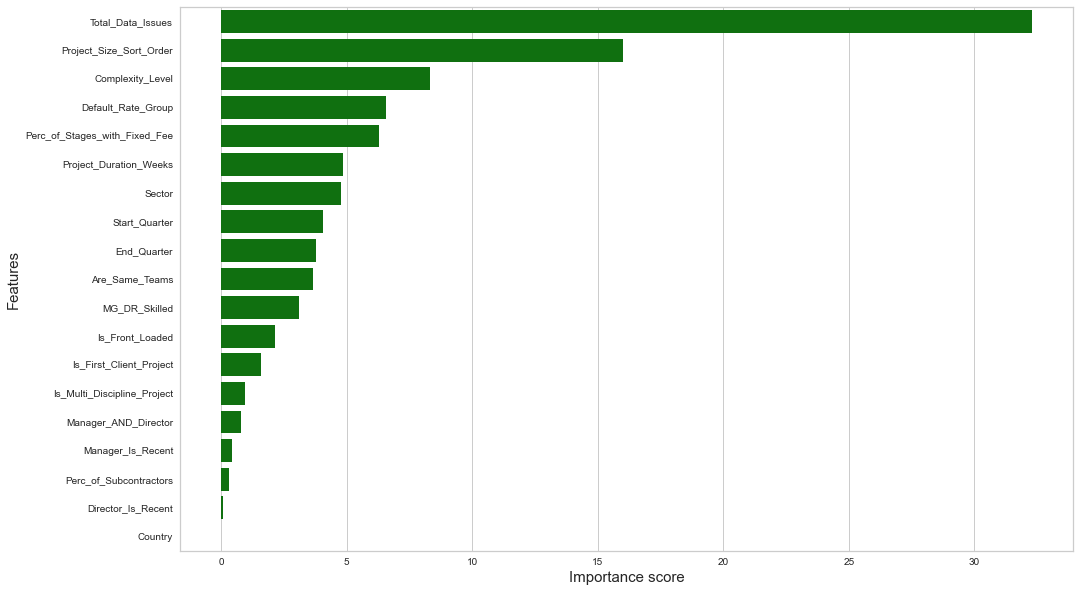

In [37]:
fig, ax = plt.subplots(figsize = (16,10))
sns.barplot(feature_imp['feature_imp'], feature_imp['feature_name'], color = 'green')
plt.xlabel('Importance score', size = 15)
plt.ylabel('Features', size = 15)
plt.xticks(rotation = 'horizontal')
plt.savefig('figures/profit/binary/Automated feature importance of the best model.png')